# Latent Semantic Analysis (LSA) - Human Rights Abuses in Qatar Part 3

In Part 3 of this project, we apply Latent Semantic Analysis (LSA) with Countvectorizer() and TFIDFVectorizer() and compare the results between these two different approaches. The main objective is to derive meaningful and interpretable topics from documents and see if there are improvements in interpretability of our Topics from the previously applied model (LDA). 

**The project Objectives for Part 3 of this project :**

**1. Find optimal number of Topics using Average Topic Coherence**
 - Check how consistent the topic is using coherence measure

**2. LSA with CountVectorizer()**
 - simply counts the number of times a word appears in a document (using a bag-of-words approach)
 
**3. LSA with TFIDFVectorizer()**
 - takes into account not only how many times a word appears in a document but also how important that word is to the whole corpus
 

### Libraries

In [2]:
import re
import math
import warnings
import itertools
import numpy as np
import pandas as pd
import plotly.express as px # for nice plotting
import matplotlib.pyplot as plt

In [3]:
import gensim # we will need some optimized calculations of DF
from gensim import corpora # for: Dictionary(), word2bow()
from nltk.tokenize import RegexpTokenizer # for LSA in sklearn, we will need additional tokenizer
from sklearn.feature_extraction.text import CountVectorizer # one can consider LSA with DF in DTM...
from sklearn.feature_extraction.text import TfidfVectorizer # or with TF-IDF values in DTM
from sklearn.decomposition import TruncatedSVD # this performs LSA!

### Import datasets

In [4]:
# import dataset tokenised_data
import pickle 
with open("outputs/df_qatar.pkl", "rb") as fp:
    df_qatar = pickle.load(fp)
    
with open("outputs/topic_clean.pkl", "rb") as fp:
    topic_clean = pickle.load(fp)

In [5]:
# review dataset
df_qatar.head()

,stemmed_tokens,qatar_tokens,qatar_texts,qatar_tokens_gensim,qatar_text_gensim
0,"[qatar, submiss, to, the, un, univers, period,...","[qatar, submission, un, universal, periodic, r...",qatar submission un universal periodic review ...,"[qatar, submission_un, universal_periodic, rev...",qatar submission_un universal_periodic review ...
1,"[qatar, submiss, to, the, un, univers, period,...","[qatar, submission, un, universal, periodic, r...",qatar submission un universal periodic review ...,"[qatar, submission_un, universal_periodic, rev...",qatar submission_un universal_periodic review ...
2,"[qatar, submiss, to, the, un, univers, period,...","[qatar, submission, un, universal, periodic, e...",qatar submission un universal periodic eview s...,"[qatar, submission_un, universal_periodic, evi...",qatar submission_un universal_periodic eview s...
3,"[qatar, submiss, to, the, un, univers, period,...","[qatar, submission, un, universal, periodic, r...",qatar submission un universal periodic review ...,"[qatar, submission_un, universal_periodic, rev...",qatar submission_un universal_periodic review ...
4,"[qatar, submiss, to, the, un, univers, period,...","[qatar, submission, un, universal, periodic, e...",qatar submission un universal periodic eview s...,"[qatar, submission_un, universal_periodic, evi...",qatar submission_un universal_periodic eview s...


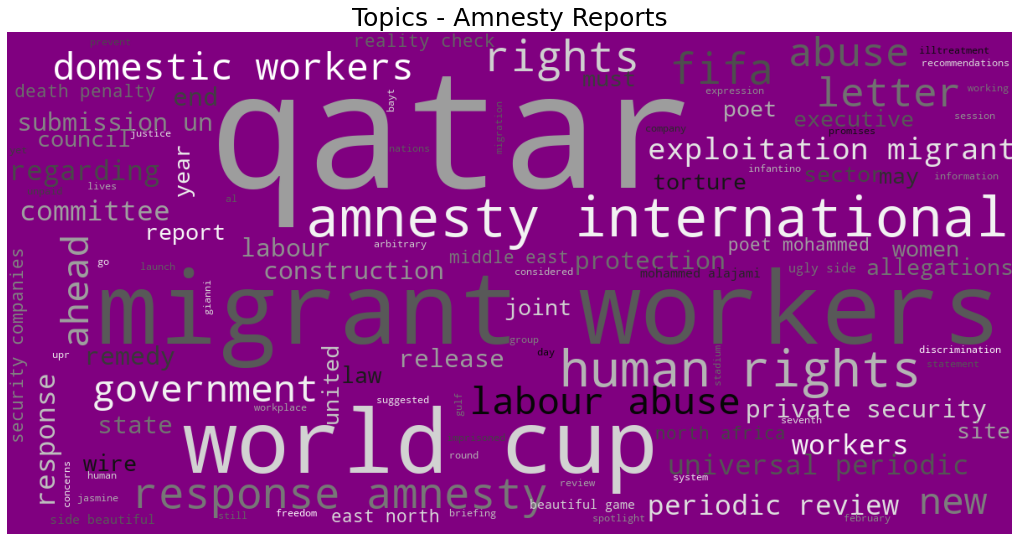

In [7]:
from wordcloud import WordCloud
cloud = WordCloud(scale=3,
                      max_words=150,
                      colormap = 'gist_gray',
                      background_color='purple',
                      collocations=True,
                      contour_color='#820263',
                      contour_width=3).generate_from_text(topic_clean)
plt.figure(figsize=(18,12))
plt.imshow(cloud)
plt.axis('off')
plt.title('Topics - Amnesty Reports', fontsize=25)
plt.show()

# 1. Find  optimal number of topics LSA

Finding optimal number of topics in LSA using CountVectorizer() and TFIDFVectorizer(). Filtering with document frequency (0.75)

In [104]:
# source: https://stackoverflow.com/questions/69730428/how-do-i-find-coherence-score-for-lsa-and-lda-for-sklearn-models
#
def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)    
    Di, Dij = col_i.sum(), col_ij.sum()    
    return math.log((Dij + 1) / Di)

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    for j_index in range(0, len(topic_top)):
        for i_index in range(0, j_index - 1):
            i = topic_top[i_index][1]
            j = topic_top[j_index][1]
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

In [99]:
tf_vectorizer = CountVectorizer(ngram_range = (1, 3),
                                max_df = 0.75, #filtering with document frequency
                                min_df = 5/len(df_qatar.qatar_texts), ##filtering with document frequency
                                tokenizer = tokenizer.tokenize
)

tf = tf_vectorizer.fit_transform(df_qatar.qatar_texts)
f_feature_names = tf_vectorizer.get_feature_names()

topic_coherence_specific = []

for n_topics in range(2,26,1):
    
    print('Trying parameters:', n_topics)
    
    lsa = TruncatedSVD(n_components = n_topics, n_iter = 25, random_state = 42) 
    #less iterations used above to not wait till tomorrow, results will be less precise though
                
    lsa.fit_transform(tf)
                
    avg_coherence = get_average_topic_coherence(tf, lsa.components_, 25)
    
    topic_coherence_specific.append([avg_coherence, n_topics])

C:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Trying parameters: 2
Trying parameters: 3
Trying parameters: 4
Trying parameters: 5
Trying parameters: 6
Trying parameters: 7
Trying parameters: 8
Trying parameters: 9
Trying parameters: 10
Trying parameters: 11
Trying parameters: 12
Trying parameters: 13
Trying parameters: 14
Trying parameters: 15
Trying parameters: 16
Trying parameters: 17
Trying parameters: 18
Trying parameters: 19
Trying parameters: 20
Trying parameters: 21
Trying parameters: 22
Trying parameters: 23
Trying parameters: 24
Trying parameters: 25


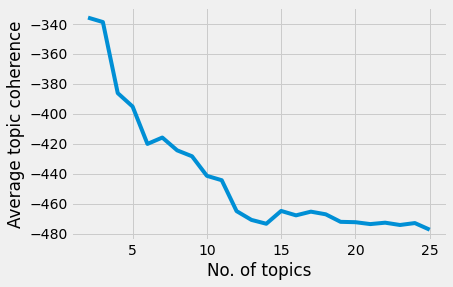

In [105]:
# below, we make the output (list) a pandas DataFrame with intuitive colnames
topic_coherence_specific_df = pd.DataFrame(topic_coherence_specific).rename(columns={
    0: 'avg_coherence', 1: 'n_topics'
})

plt.style.use("fivethirtyeight")
plt.plot(topic_coherence_specific_df['n_topics'],topic_coherence_specific_df['avg_coherence'])
plt.xlabel("No. of topics")
plt.ylabel("Average topic coherence")
plt.show()

In [106]:
# descending sorting by average topic coherence
topic_coherence_specific_df.sort_values('avg_coherence', ascending = False).iloc[0:9,:]

,avg_coherence,n_topics
0,-335.856306,2
1,-338.816923,3
2,-386.254111,4
3,-395.215279,5
5,-415.918349,7
4,-420.169206,6
6,-424.466399,8
7,-428.413407,9
8,-441.470475,10


 Optimal number of topics is 2. Next recommendations are: 3, 4, 5, 7, ...

# 2. LSA using  CountVectorizer() 

We make use of CountVectorizer() to convert a collection of text documents to a matrix of token counts. We apply already preprocessed data in the model, and we will filter corpus using DF = 0.75.

## Optimal LSA model (2 topics) with CountVectorizer()

In [109]:
tf_vectorizer = CountVectorizer(ngram_range = (1, 1),
                                max_df = 0.75, #filtering with document frequency
                                min_df = 5/len(df_qatar.qatar_texts), ##filtering with document frequency
                                tokenizer = tokenizer.tokenize
)

tf = tf_vectorizer.fit_transform(df_qatar.qatar_texts)
tf_feature_names = tf_vectorizer.get_feature_names()

lsa = TruncatedSVD(n_components = 2, 
                   n_iter = 25,
                   random_state = 42)

model = lsa.fit_transform(tf)

for index, component in enumerate(lsa.components_):
    zipped = zip(tf_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    
    print("Topic "+str(index+1)+": ",top_terms_list)

Topic 1:  ['workers', 'qatar', 'rights', 'migrant', 'labour', 'human', 'world', 'cup', 'law', 'domestic']
Topic 2:  ['rights', 'human', 'fifa', 'un', 'social', 'world', 'economic', 'accessed', 'cultural', 'right']


In [115]:
# source: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

def plot_top_words(model, feature_names, n_top_words, title = '', subplotx = 2, subploty = 5):
    fig, axes = plt.subplots(subplotx, subploty, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30}) 
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20) #20, 35
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


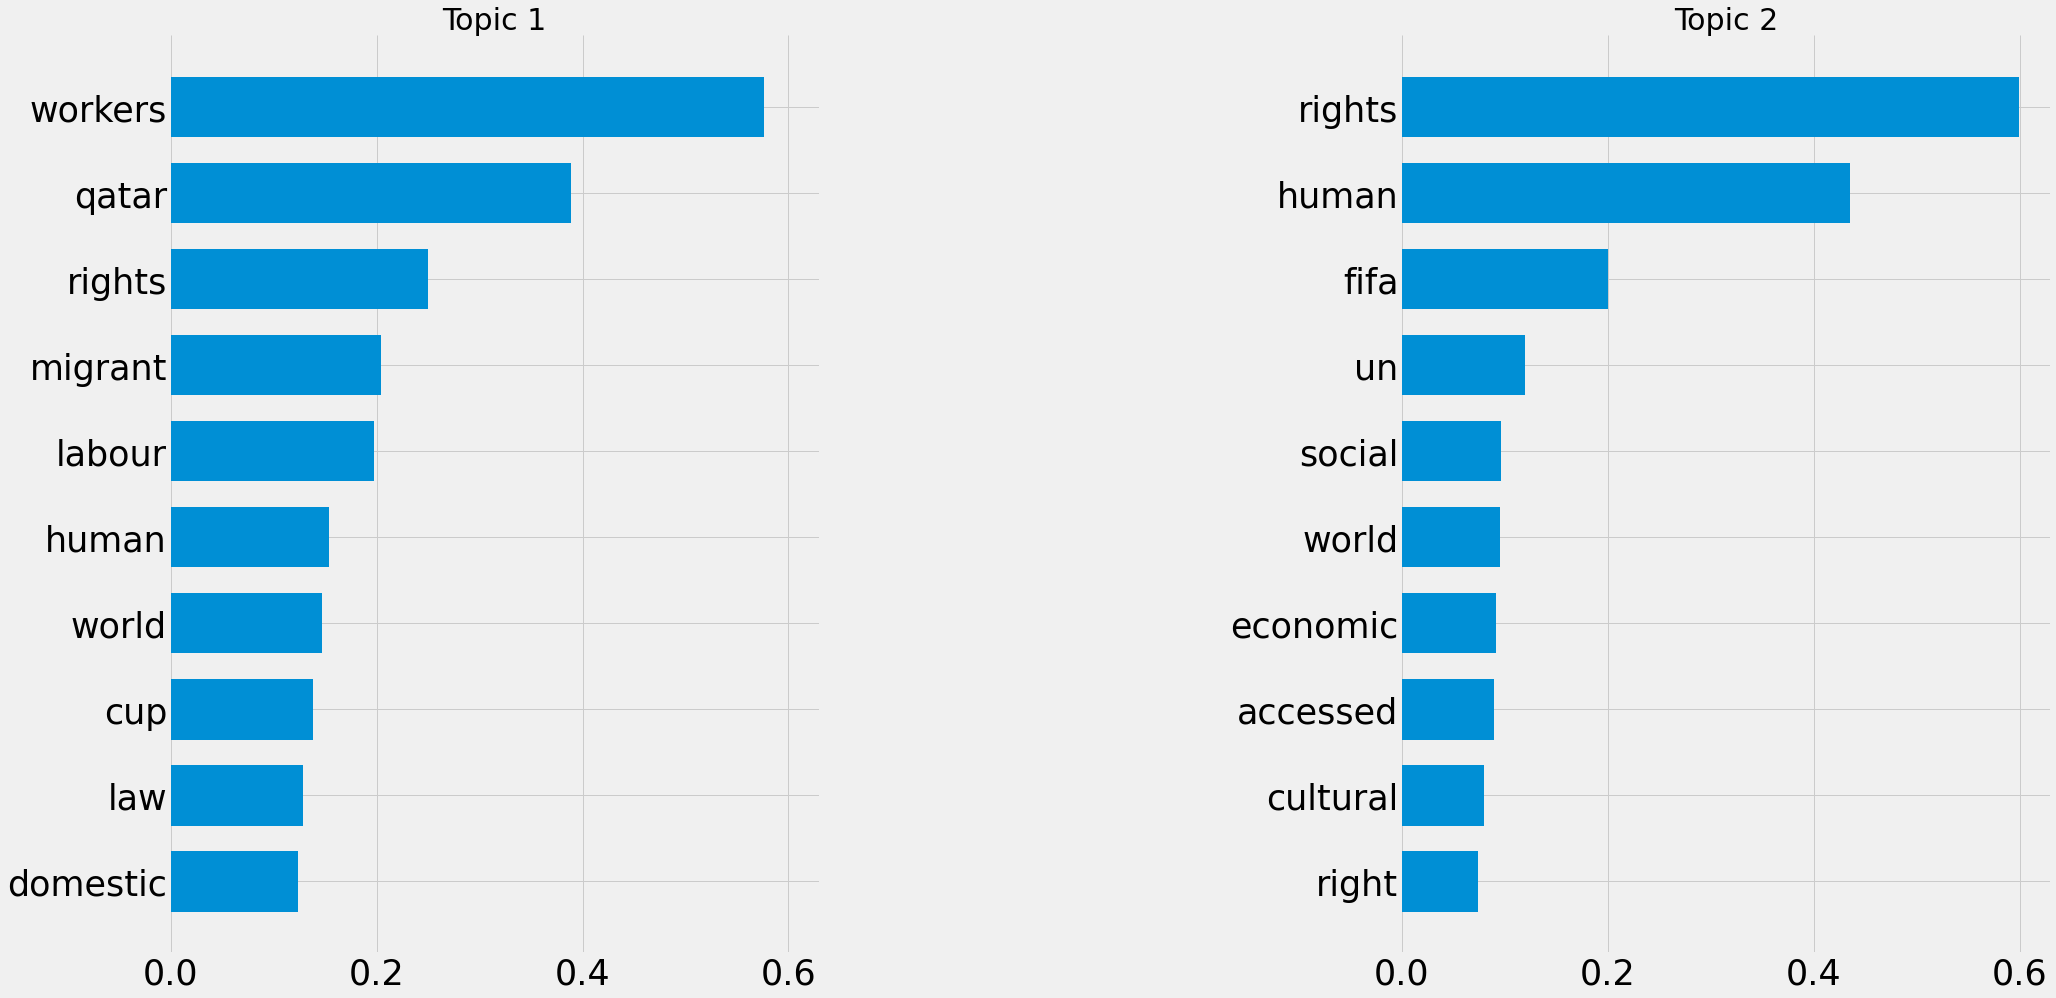

In [112]:
plot_top_words(lsa, tf_feature_names, 10, title = '', subplotx = 1, subploty = 2)

Topic 1 is about domestic and migrant workers and the World Cup in qatar

Topic 2 is about Rights (human, economic, social, cultural)


## LSA model (20 topics) with CountVectorizer()

Although 2 is an Optimal number of Topics as suggested using a Coherence measure, we will, however, consider a higher value for the number of Topics so that we get more representative sample of the topics present in the documents.

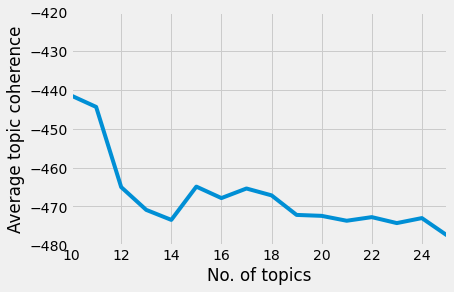

In [113]:
topic_coherence_specific_df = pd.DataFrame(topic_coherence_specific).rename(columns={
    0: 'avg_coherence', 1: 'n_topics'
})

plt.style.use("fivethirtyeight")
plt.plot(topic_coherence_specific_df['n_topics'],topic_coherence_specific_df['avg_coherence'])
plt.xlim([10, 25])
plt.ylim([-480, -420])
plt.xlabel("No. of topics")
plt.ylabel("Average topic coherence")
plt.show()

Plotting the Average Topic Coherence from topic 10 to see the stabiliy of our topics suggested by the Coherence

In [114]:
# descending sorting by average topic coherence
topic_coherence_specific_df.sort_values('avg_coherence', ascending = False).iloc[10:20,:]

,avg_coherence,n_topics
13,-464.907168,15
10,-465.030466,12
15,-465.392217,17
16,-467.154369,18
14,-467.854793,16
11,-470.891197,13
17,-472.184601,19
18,-472.426461,20
20,-472.753720,22
22,-473.001755,24


In [133]:
tf_vectorizer = CountVectorizer(ngram_range = (1, 3),
                                max_df = 0.75, #filtering with document frequency
                                min_df = 5/len(df_qatar.qatar_texts), ##filtering with document frequency
                                tokenizer = tokenizer.tokenize
)

tf = tf_vectorizer.fit_transform(df_qatar.qatar_texts)
tf_feature_names = tf_vectorizer.get_feature_names()

lsa = TruncatedSVD(n_components = 20, 
                   n_iter = 25,
                   random_state = 42)

model = lsa.fit_transform(tf)

for index, component in enumerate(lsa.components_):
    zipped = zip(tf_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    
    print("Topic "+str(index+1)+": ",top_terms_list)

Topic 1:  ['workers', 'qatar', 'rights', 'migrant', 'labour', 'migrant workers', 'human', 'world', 'cup', 'human rights']
Topic 2:  ['rights', 'human', 'human rights', 'fifa', 'un', 'world', 'social', 'economic', 'accessed', 'cultural']
Topic 3:  ['fifa', 'cup', 'world', 'world cup', 'qatar', 'supreme committee', 'supreme', 'committee', 'welfare', 'workers welfare']
Topic 4:  ['domestic', 'domestic workers', 'fifa', 'workers', 'rights', 'human', 'human rights', 'women', 'employers', 'abuse']
Topic 5:  ['supreme', 'standards', 'committee', 'supreme committee', 'welfare', 'workers welfare', 'welfare standards', 'workers', 'workers welfare standards', 'sc']
Topic 6:  ['fifa', 'death', 'domestic', 'domestic workers', 'women', 'penalty', 'qatar', 'death penalty', 'authorities', 'cup']
Topic 7:  ['said', 'company', 'told', 'work', 'interview', 'would', 'doha', 'human', 'working', 'day']
Topic 8:  ['qatar', 'accessed', 'convention', 'domestic', 'committee', 'ratified', 'doha', 'interview', 'd

<Figure size 864x576 with 0 Axes>

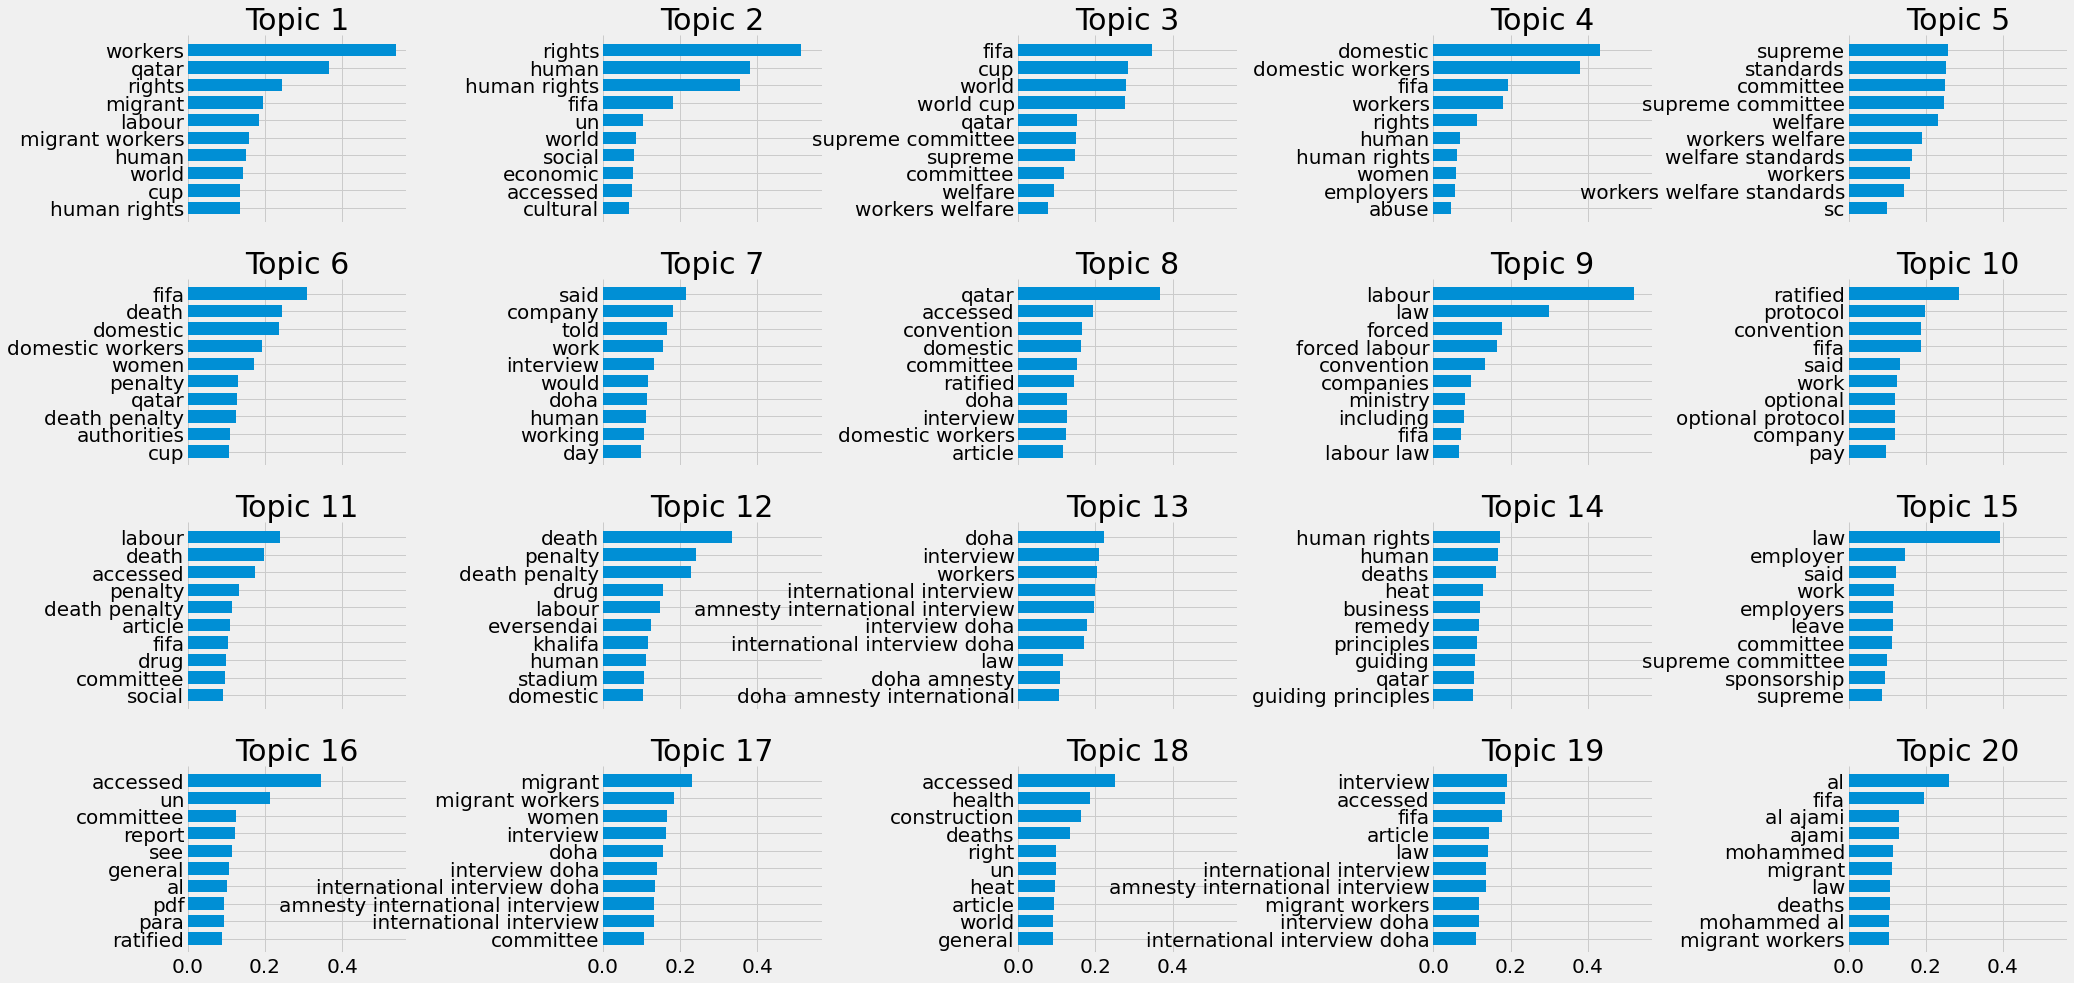

In [134]:
plt.figure(figsize=(12,8))
plot_top_words(lsa, tf_feature_names, 10, title = '', subplotx = 4, subploty = 5)


**20 interpretable Topics using CountVectorizer()**

- Topic 1 - Human rights and migrant workers
- Topic 2 - United Nations, FIFA and human rights
- Topic 3 - Supreme committee and workers welfare.  (The Supreme Committee is a governmental body in Qatar established in 2011 to ensure the successful delivery of projects for the FIFA World Cup 202)
- Topic 4 - Domestic workers and women abuse
- Topic 5 - Workers welfare standards and Supreme Committee
- Topic 6 - Authorities, death penalty and women
- Topic 7 - Company interview in doha
- Topic 8 - Domestic workers interview and article
- Topic 9 - Forced labour, labour law, the ministry and companies
- Topic 10 - Ratified convention and PAY
- Topic 11 - Drugs and death penalty
- Topic 12 - Death penalty, drugs, eversendai and Khalifa stadium
- Topic 13 - Amnesty International Interviews in Doha
- Topic 14 - Deaths caused by heat, and principles
- Topic 15 - Employers sponsership, law and supreme committe
- Topic 16 - United general committe and reports
- Topic 17 - Amnesty International interview, migrants workers and women
- Topic 18 - Deaths caused by heat and health
- Topic 19 - Amnesty International interview
- Topic 20 - Al jamali mohammed and migrant workers deaths

The results of the model show interpretability of topics.

However there is also an overlap of topics which doesn't show much dinstictiveness of Topics i.e., **Topic 3 and 5** are very similar, and also **Topics 13, 17, 19** are very similar topics and could be combined as one topic

# 3. LSA using TfidfVectorizer() 

Another option for cleaning raw data in an easy and quick way with commands from sklearn library is using TfidfVectorizer(). It converts a collection of text documents to a matrix of TF-IDF values. It enables filtering data with respect to tokens' document frequency (again, IDF but not inverse).

Let us assume previously determined DF cut-offs and optimize the number of topics for this case.

In [126]:
tf_vectorizer = TfidfVectorizer(ngram_range = (1, 3),
                                max_df = 0.75, #filtering with document frequency
                                min_df = 5/len(df_qatar.qatar_texts), ##filtering with document frequency
                                tokenizer = tokenizer.tokenize
)

tf = tf_vectorizer.fit_transform(df_qatar.qatar_texts)
f_feature_names = tf_vectorizer.get_feature_names()

topic_coherence_specific = []

for n_topics in range(2,26,1):
    
    print('Trying parameters:', n_topics)
    
    lsa = TruncatedSVD(n_components = n_topics, n_iter = 25, random_state = 42) 
    #less iterations used above to not wait till tomorrow, results will be less precise though
                
    lsa.fit_transform(tf)
                
    avg_coherence = get_average_topic_coherence(tf, lsa.components_, 25)
    
    topic_coherence_specific.append([avg_coherence, n_topics])

C:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Trying parameters: 2
Trying parameters: 3
Trying parameters: 4
Trying parameters: 5
Trying parameters: 6
Trying parameters: 7
Trying parameters: 8
Trying parameters: 9
Trying parameters: 10
Trying parameters: 11
Trying parameters: 12
Trying parameters: 13
Trying parameters: 14
Trying parameters: 15
Trying parameters: 16
Trying parameters: 17
Trying parameters: 18
Trying parameters: 19
Trying parameters: 20
Trying parameters: 21
Trying parameters: 22
Trying parameters: 23
Trying parameters: 24
Trying parameters: 25


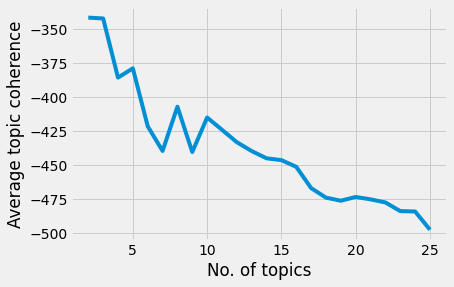

In [127]:
# below, we make the output (list) a pandas DataFrame with intuitive colnames
topic_coherence_specific_tfidf = pd.DataFrame(topic_coherence_specific).rename(columns={
    0: 'avg_coherence', 1: 'n_topics'
})
plt.style.use("fivethirtyeight")
plt.plot(topic_coherence_specific_tfidf['n_topics'],topic_coherence_specific_tfidf['avg_coherence'])
plt.xlabel("No. of topics")
plt.ylabel("Average topic coherence")
plt.show()

In [128]:
# descending sorting by average topic coherence
topic_coherence_specific_tfidf.sort_values('avg_coherence', ascending = False).iloc[0:9,:]

,avg_coherence,n_topics
0,-341.545658,2
1,-342.167796,3
3,-378.841936,5
2,-385.646923,4
6,-407.058287,8
8,-415.004537,10
4,-421.411184,6
9,-424.026898,11
10,-433.157035,12


# Optimal LSA model (2 topics) with TfidfVectorizer()

In [129]:
tf_vectorizer = TfidfVectorizer(ngram_range = (1, 3),
                                max_df = 0.75, #filtering with document frequency
                                min_df = 5/len(df_qatar.qatar_texts), ##filtering with document frequency
                                tokenizer = tokenizer.tokenize
)

tf = tf_vectorizer.fit_transform(df_qatar.qatar_texts)
tf_feature_names = tf_vectorizer.get_feature_names()

lsa = TruncatedSVD(n_components = 2, 
                   n_iter = 25,
                   random_state = 42)

model = lsa.fit_transform(tf)

for index, component in enumerate(lsa.components_):
    zipped = zip(tf_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    
    print("Topic "+str(index+1)+": ",top_terms_list)

C:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 1:  ['workers', 'qatar', 'rights', 'domestic', 'labour', 'migrant', 'domestic workers', 'migrant workers', 'human', 'law']
Topic 2:  ['death', 'death penalty', 'penalty', 'rights', 'drug', 'human', 'human rights', 'drugs', 'offences', 'economic']


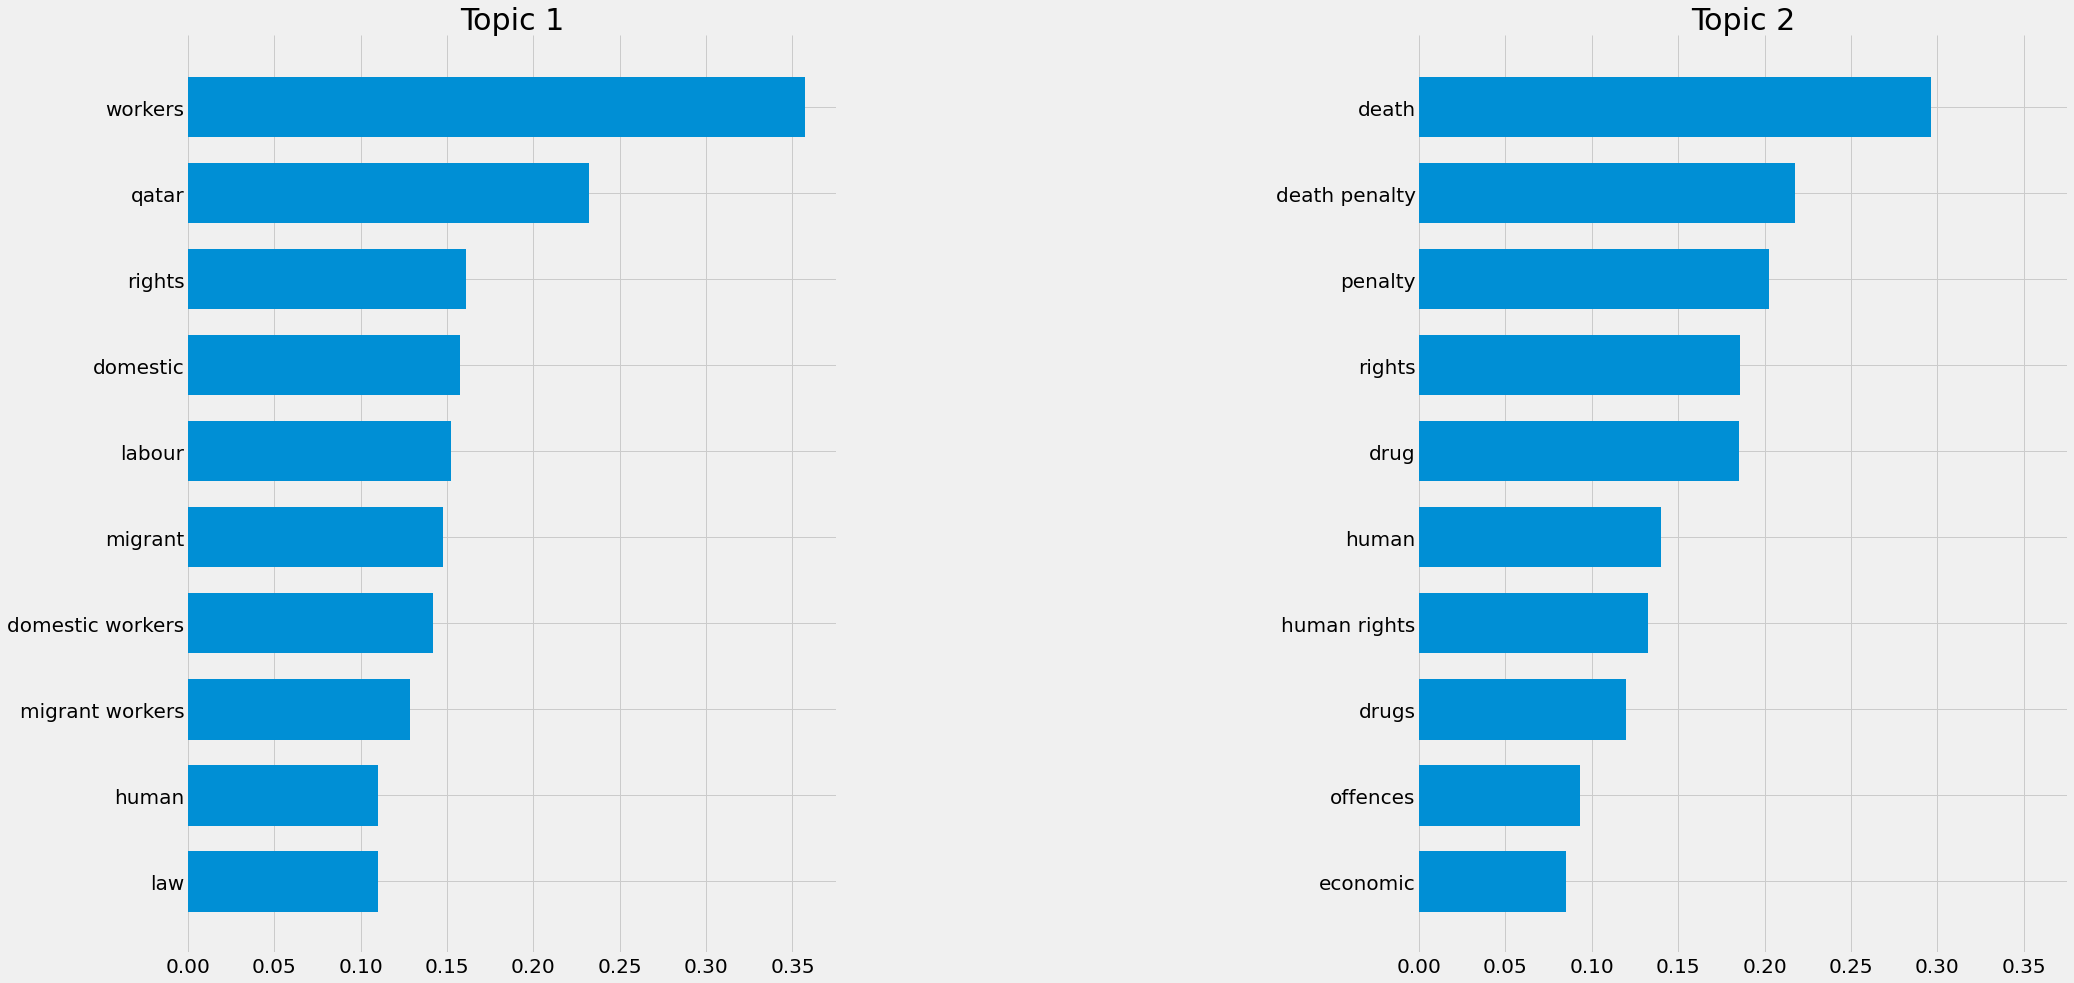

In [130]:
plot_top_words(lsa, tf_feature_names, 10, title = '', subplotx = 1, subploty = 2)

Topic 1 is about domestic and migrant workers and the World Cup in qatar

Topic 2 is about death penalty and drug offenses

## LSA model (20 topics) with TfidfVectorizer()

Although 2 is an Optimal number of Topics as suggested using a Coherence measure, we will, however, consider a higher value for the number of Topics so that we get more insight in the number of topics in our corpus.

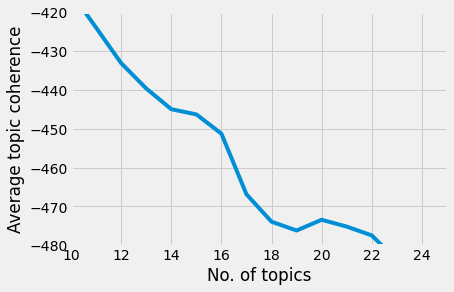

In [136]:
# below, we make the output (list) a pandas DataFrame with intuitive colnames
topic_coherence_specific_tfidf = pd.DataFrame(topic_coherence_specific).rename(columns={
    0: 'avg_coherence', 1: 'n_topics'
})
plt.style.use("fivethirtyeight")
plt.plot(topic_coherence_specific_tfidf['n_topics'],topic_coherence_specific_tfidf['avg_coherence'])
plt.xlim([10, 25])
plt.ylim([-480, -420])
plt.xlabel("No. of topics")
plt.ylabel("Average topic coherence")
plt.show()

In [137]:
# descending sorting by average topic coherence
topic_coherence_specific_tfidf.sort_values('avg_coherence', ascending = False).iloc[10:20,:]

,avg_coherence,n_topics
11,-439.667331,13
7,-440.379899,9
12,-444.995822,14
13,-446.334806,15
14,-451.281043,16
15,-466.885007,17
18,-473.431364,20
16,-473.932386,18
19,-475.189975,21
17,-476.195770,19


In [131]:
tf_vectorizer = TfidfVectorizer(ngram_range = (1, 3),
                                max_df = 0.75, #filtering with document frequency
                                min_df = 5/len(df_qatar.qatar_texts), ##filtering with document frequency
                                tokenizer = tokenizer.tokenize
)

tf = tf_vectorizer.fit_transform(df_qatar.qatar_texts)
tf_feature_names = tf_vectorizer.get_feature_names()

lsa = TruncatedSVD(n_components = 20, 
                   n_iter = 25,
                   random_state = 42)

model = lsa.fit_transform(tf)

for index, component in enumerate(lsa.components_):
    zipped = zip(tf_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    
    print("Topic "+str(index+1)+": ",top_terms_list)

Topic 1:  ['workers', 'qatar', 'rights', 'domestic', 'labour', 'migrant', 'domestic workers', 'migrant workers', 'human', 'law']
Topic 2:  ['death', 'death penalty', 'penalty', 'rights', 'drug', 'human', 'human rights', 'drugs', 'offences', 'economic']
Topic 3:  ['fifa', 'rights', 'cup', 'world cup', 'world', 'human rights', 'human', 'supreme committee', 'supreme', 'welfare']
Topic 4:  ['death', 'drug', 'death penalty', 'penalty', 'drugs', 'offences', 'drug offences', 'fifa', 'act', 'trafficking']
Topic 5:  ['ratified', 'protocol', 'convention', 'optional protocol', 'optional', 'geneva conventions', 'geneva', 'relating', 'overdue', 'conventions']
Topic 6:  ['domestic', 'domestic workers', 'fifa', 'ratified', 'protocol', 'convention', 'supreme committee', 'workers', 'optional', 'optional protocol']
Topic 7:  ['domestic', 'domestic workers', 'women', 'sc', 'eversendai', 'khalifa', 'stadium', 'aspire', 'welfare', 'nakheel']
Topic 8:  ['commons', 'creative commons', 'creative', 'material',

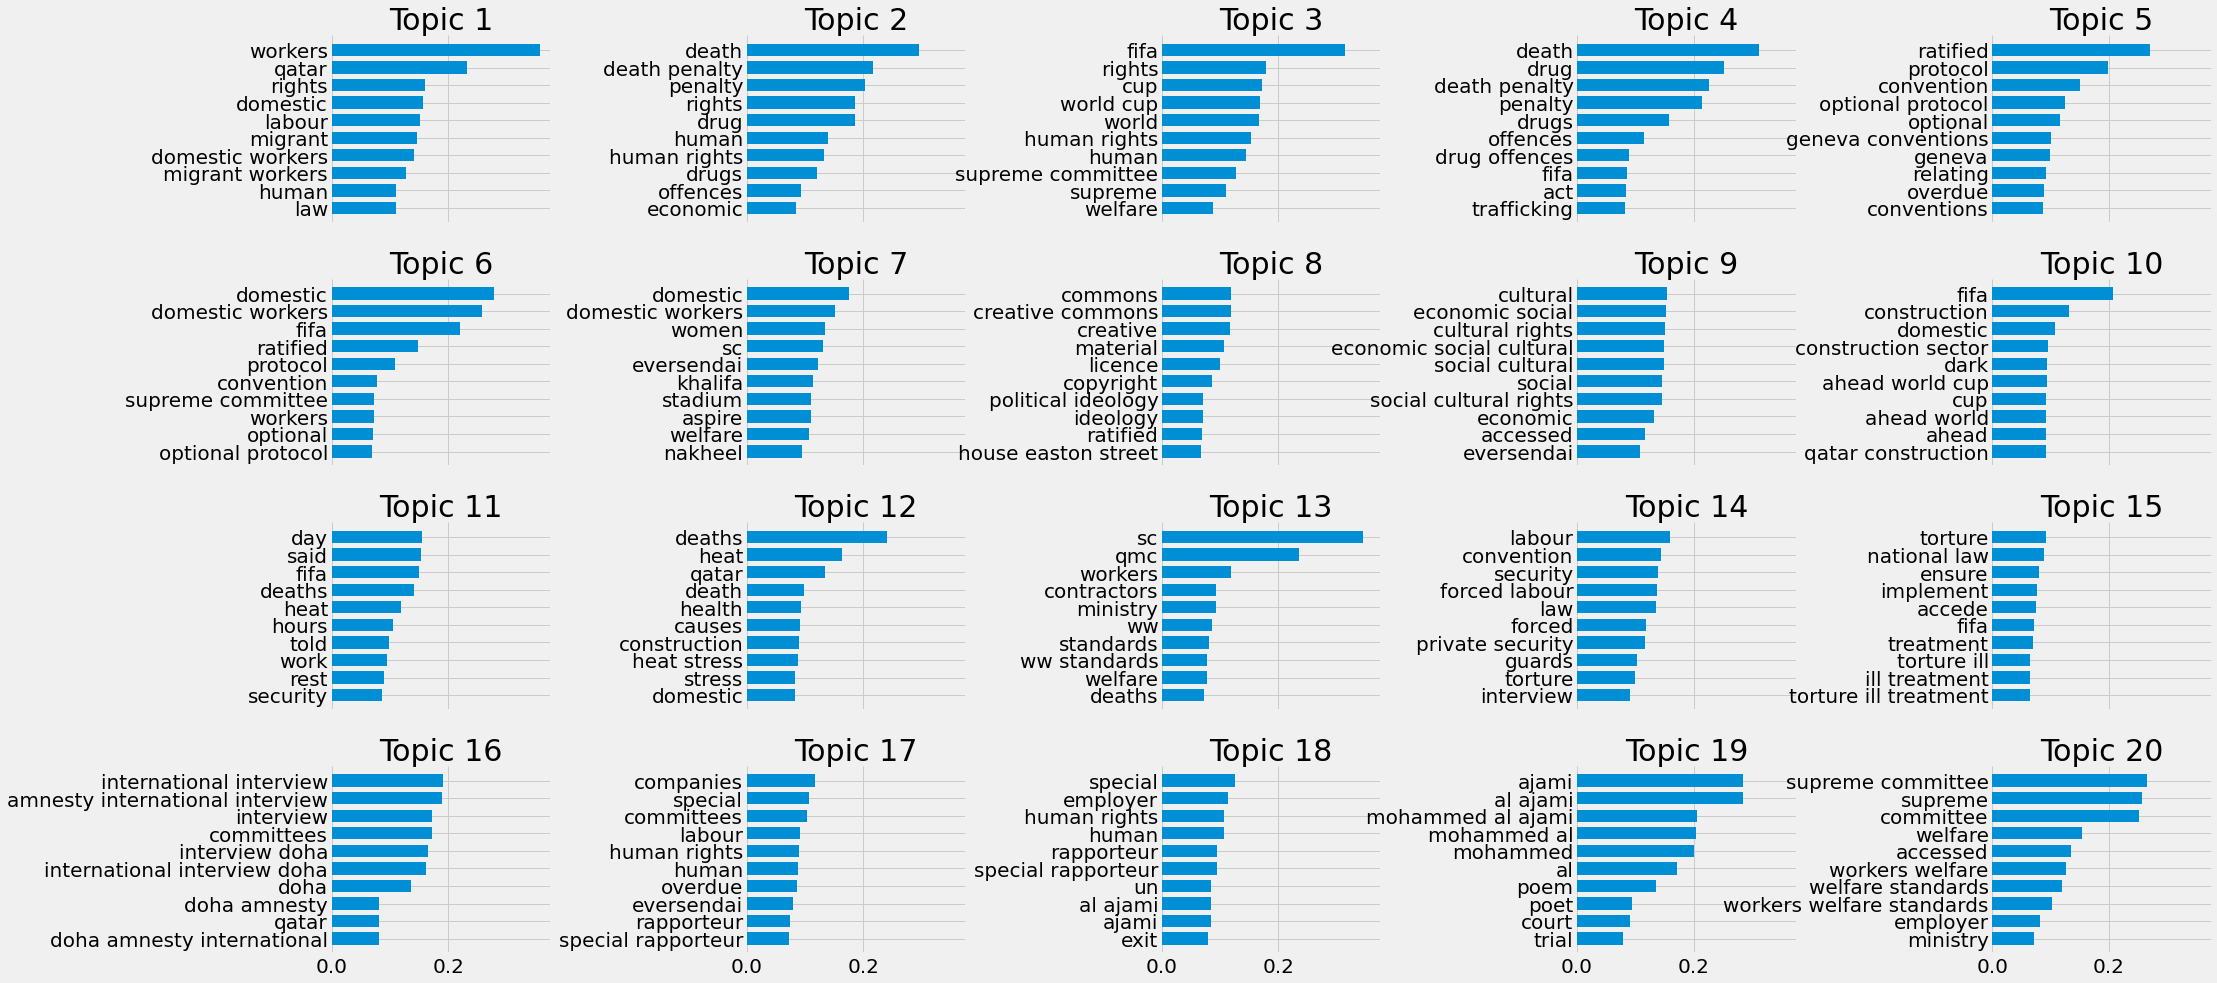

In [132]:
plot_top_words(lsa, tf_feature_names, 10, title = '', subplotx = 4, subploty = 5)

**20 interpretable Topics using TidfVectorizer()**
- Topic 1 - Domestic and migrant workers in qatar
- Topic 2 - Drug offenses and death penalty
- Topic 3 - Supreme committe and human rights and welfare
- Topic 4 - Drug offenses, trafficking and death penalty
- Topic 5 - Overdue Gevena conventions
- Topic 6 - Domestic workers and supreme committe conventions
- Topic 7 - Construction companies (Eversendai, Aspire, Nakheel) welfare for domestic workers who worked at Khalifa Stadium
- Topic 8 - creative commons, copyright, political idealogy
- Topic 9 - Rights (social, economic, cultural) and Eversendai
- Topic 10 - Construction sector ahead of FIFA world cup
- Topic 11 - Deaths caused by heat and work hours
- Topic 12 - Heat and heat stress causes of deaths in Construction in Qatar
- Topic 13 - Supreme Committee (SC), Qatar Medical Centre (QMC)) standards, workers welfare
- Topic 14 - Private security, guards, torture and forced labour
- Topic 15 - Ill treatment and torture, national Law
- Topic 16 - Amnesty Internation Interview in Doha
- Topic 17 - Overdue special rapporteur from companies (Eversendai)
- Topic 18 - Al ajami special rapporteur and human rights
- Topic 19 - Mohammed Al Ajami court trial
- Topic 20 - Workers welfare standards and the ministry

Using TfidfVectorizer(), we realise dinstictive of topics.

# Conclusion

With Latent Semantic Analysis (LSA), topics were generally interpretable using both LSA with Tfidf and CountVectorizer(). There is also much similarity in terms of Topics discovered in the model for both Tfidf and CountVectorizer.

Comparing LSA model with Latent Dirichlet Allocations (LDA) model, based on the results of both models, I concluded that LDA derived more interpretable topics as compared to LSA. And also, LDA model derived other topics that are **NOT derived** using LSA for both Tfidf and CountVectorizer(). 

Example of these topics from LDA model include:

- Topics on Abusive Labur Migrations from China, Migrants from Italy, Low income migrants from Nepal, Malaysia, Africa
- Topics on mentioning of names such as Yam Bahadur (migrant worker from Nepal who died in Qatar), Professor Vivekanand Jha, Mohammed Suman Miah and Sujan Miah (migrants workers from Bangladesh who died in qatar)
- Topics on Kalafa system - (Kafali system is a sponsorship system that governs the employment of migrant workers in qatar. Migrant workers are tied to their sponsor and are not allowed to change jobs or leave the country without the sponsor's permission.)
- Topics on Changing names to protect migrant workers working at Khaifa stadium and Eversendai due to interviews conducted by Amnesty International

- Topics on  Residence permits and undocumented workers
- Topics on Forced labour abuse in Qatar and cassation upheld in countries including Netherlands, Korea, Palentine. Cassation generally refers to any type of appeal to a higher court.